In [1]:
# import dependencies
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T # for later data augmentation
from typing import Sequence
from torch.nn import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,  DataLoader, TensorDataset

In [2]:
# for better visualization during preprocessing, we view tensors and PIL images
t2img = T.ToPILImage() # tensor to pil image
img2t = T.ToTensor() # pil image to tensor

In [2]:
print(f"Cuda: {torch.cuda.is_available()}")

Cuda: True


In [4]:
working_dir = './'

# Useful tool functions

In [5]:
# save model status and checkpoint
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join(working_dir, cp_name))

# get the current device: cpu or gpu
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
# If map_location is a torch.device object or a string containing a device tag, it indicates the location where all tensors should be loaded.
def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

# send tensor and model to the device
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

# get the total number of parameters of the model
def get_model_parameters(m): # numel: total number of elements
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

# print the total number of parameters
def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")

In [6]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

# Explore the data

The images are jpg images, with three channels and values between 0 and 255.

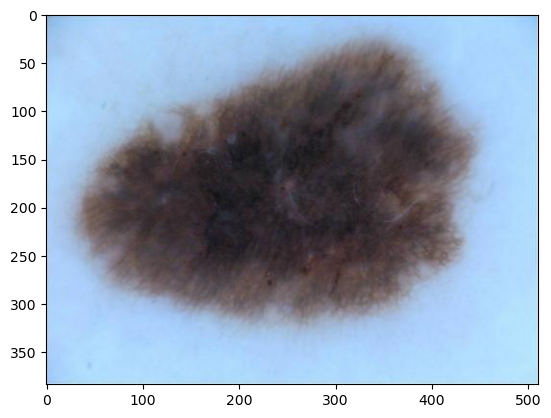

In [6]:
sample_image = Image.open('./data/Train/Train/ISIC_0000000.jpg')
plt.imshow(sample_image)

In [12]:
sample_image_array = np.array(sample_image)
sample_image_array.shape

(384, 511, 3)

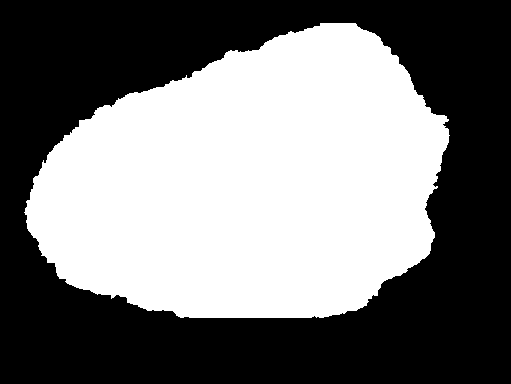

In [13]:
sample_image_gt = Image.open('./data/Train/Train/ISIC_0000000_seg.png')
sample_image_gt

In [14]:
sample_image_gt_array = np.array(sample_image_gt)
sample_image_gt_array.shape

(384, 511)

We can see that for the ground truth, we have a single channel image with values between 0 and 255.

In [18]:
np.unique(sample_image_gt_array)

array([  0, 255], dtype=uint8)

In [21]:
# we concate the ground truth mask as the fourth channel of the image
sample_image_array = np.concatenate((sample_image_array, np.expand_dims(sample_image_gt_array, axis=2)), axis=2)

In [22]:
sample_image_array

array([[[212, 236, 255,   0],
        [182, 206, 232,   0],
        [183, 209, 236,   0],
        ...,
        [185, 221, 255,   0],
        [190, 220, 248,   0],
        [218, 240, 255,   0]],

       [[182, 206, 232,   0],
        [149, 173, 201,   0],
        [148, 173, 203,   0],
        ...,
        [155, 191, 227,   0],
        [162, 192, 220,   0],
        [191, 213, 237,   0]],

       [[185, 211, 238,   0],
        [150, 176, 203,   0],
        [145, 172, 201,   0],
        ...,
        [155, 193, 229,   0],
        [164, 195, 224,   0],
        [194, 218, 242,   0]],

       ...,

       [[187, 215, 239,   0],
        [166, 196, 222,   0],
        [162, 191, 223,   0],
        ...,
        [182, 217, 236,   0],
        [191, 221, 232,   0],
        [204, 227, 235,   0]],

       [[190, 218, 240,   0],
        [173, 200, 227,   0],
        [168, 197, 229,   0],
        ...,
        [188, 221, 238,   0],
        [195, 223, 234,   0],
        [206, 229, 235,   0]],

       [[208

# Preprocessing

We concate the ground truth mask as the fourth channel of the image for all the image in the dataset.

In the meantime, we should notice that not all the images have a ground truth mask. We should only concate the ground truth mask for the images that have it. If they represent for the majority image, we can drop the images without ground truth mask. If not, we can use a different approach to handle the missing ground truth mask.

In [24]:
# create a list for all the concatenated images
all_images = []
# create a list for the name of the images which have missing ground truth mask
missing_gt = []
# iterate through the directory, we can get the name of the image because they are in jpg format, and then get the corresponding ground truth mask by adding _seg.png at the end and they are in png format and in the same directory;
# also, we print a message if the ground truth mask is missing
for image in os.listdir('./data/Train/Train'):
    if image.endswith('.jpg'):
        image_name = image.split('.')[0]
        image_path = f'./data/Train/Train/{image}'
        image = Image.open(image_path)
        image_array = np.array(image)
        gt_path = f'./data/Train/Train/{image_name}_seg.png'
        if path.exists(gt_path):
            gt = Image.open(gt_path)
            gt_array = np.array(gt)
            image_array = np.concatenate((image_array, np.expand_dims(gt_array, axis=2)), axis=2)
            all_images.append(image_array)
        else:
            print(f"Ground truth mask is missing for {image_name}")
            missing_gt.append(image_name)

Ground truth mask is missing for ISIC_0000002
Ground truth mask is missing for ISIC_0000010
Ground truth mask is missing for ISIC_0000114
Ground truth mask is missing for ISIC_0000118
Ground truth mask is missing for ISIC_0000174
Ground truth mask is missing for ISIC_0000237
Ground truth mask is missing for ISIC_0000285
Ground truth mask is missing for ISIC_0000289
Ground truth mask is missing for ISIC_0000302
Ground truth mask is missing for ISIC_0000333
Ground truth mask is missing for ISIC_0000347
Ground truth mask is missing for ISIC_0000369
Ground truth mask is missing for ISIC_0000371
Ground truth mask is missing for ISIC_0000445
Ground truth mask is missing for ISIC_0000452
Ground truth mask is missing for ISIC_0000467
Ground truth mask is missing for ISIC_0000468
Ground truth mask is missing for ISIC_0000475
Ground truth mask is missing for ISIC_0000478
Ground truth mask is missing for ISIC_0000516
Ground truth mask is missing for ISIC_0001187
Ground truth mask is missing for I

In [27]:
len(missing_gt)

17053

In [28]:
len(all_images)

1945

In the benchmark model, we use all the images, we ignore the existence of the ground truth masks

# Model 1: benchmark with nearly no preprocessing)

We observe that as input, we can put sex, age and pathology position as well as features, but here we ignore it in the bench mark model.

## Dataset Creation

We take all the jpg pictures, and put them in a huge array to be the dataset.

We then do a train-test split, and create a dataloader for each of them.

In [45]:
# read the images according to the order of the dataframe image name

# read the metadata
meta_data_train = pd.read_csv('./data/metadataTrain.csv')
y = meta_data_train['CLASS'].values
y = y-1

# get the image names
image_names = list(meta_data_train['ID'].values)

array(['ISIC_0028766', 'ISIC_0071222', 'ISIC_0069434', ...,
       'ISIC_0030034', 'ISIC_0027095', 'ISIC_0031967'], dtype=object)

In [46]:
all_images = []
for image in image_names:
    image_path = f'./data/Train/Train/{image}.jpg'
    image = Image.open(image_path)
    image_array = np.array(image)
    all_images.append(image_array)
    # print(image_array.shape)
print(len(all_images))

18998


In [7]:
# # create a list for all the jpg images
# all_images = []
# # iterate through the directory, read them in as 3 channel images, and then append them to the list
# for image in os.listdir('./data/Train/Train'):
#     if image.endswith('.jpg'):
#         image_path = f'./data/Train/Train/{image}'
#         image = Image.open(image_path)
#         image_array = np.array(image)
#         all_images.append(image_array)
#         # print(image_array.shape)
# print(len(all_images))

18998


We then realize that the images have different sizes, so we need to resize them to the same size.

In [47]:
# we will make all the images into the size of 512*512, which is the largest size, for those who are smaller, we use zero padding, there is not larger images
# write a loop to resize all the image arrays
all_images_pad = []
for i in range(len(all_images)):
    h, w, _ = all_images[i].shape
    # Initialize a new array of zeros of shape (512, 512, 3) for padding
    padded_image = np.zeros((512, 512, 3), dtype=all_images[0].dtype)

    # Calculate padding sizes
    pad_h = (512 - h) // 2
    pad_w = (512 - w) // 2

    # Update the padded_image with the original image centered
    padded_image[pad_h:pad_h+h, pad_w:pad_w+w, :] = all_images[i]

    # Append the padded image to the list
    all_images_pad.append(padded_image)
    if i % 5000 == 0:
        print(f"{i} images have been padded")


0 images have been padded
5000 images have been padded
10000 images have been padded
15000 images have been padded


In [ ]:
# put the list into an array
# all_images_pad = np.array(all_images_pad)

In [48]:
# reduce the resolution of the images to 256*256
all_images_pad = np.array([np.array(Image.fromarray(image).resize((128, 128))) for image in all_images_pad])

Here we create the feature tensor, and also read in the csv to get the target labels.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(all_images_pad, y, test_size=0.2, random_state=42, shuffle=True)

In [50]:
class CustomImageDataset(Dataset):
    def __init__(self, image_arrays, labels, transform=None):
        """
        Args:
            image_arrays (np.array): An array of Numpy arrays representing the images.
            labels (np.array): An array of labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_arrays = image_arrays
        # Ensure labels are in a compatible format (np.array or list)
        self.labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
        self.transform = transform

    def __len__(self):
        return len(self.image_arrays)

    def __getitem__(self, idx):
        image = self.image_arrays[idx]

        # Convert image from numpy array to PIL Image to apply torchvision transforms
        image = Image.fromarray(image.astype('uint8'), 'RGB')  # Ensure the data type and mode are correct

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Make sure X_train, y_train, X_test, y_test are defined and correctly formatted
# For example purposes, assuming they're already defined and loaded...

transform = T.Compose([
    T.ToTensor(),
])

dataset_train = CustomImageDataset(X_train, y_train, transform=transform)
dataset_test = CustomImageDataset(X_test, y_test, transform=transform)

batch_size = 32  # Define your batch size

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [51]:
(train_inputs_0, train_targets_0) = next(iter(dataloader_train))

In [52]:
(test_inputs, test_targets) = next(iter(dataloader_test))

In [53]:
train_targets_0.shape

torch.Size([32])

In [54]:
train_inputs_0.shape

torch.Size([32, 3, 128, 128])

In [55]:
empty_tensor = torch.empty(128, 128, 3)
sample_tensor0 = torch.tensor(all_images_pad[0]/255, dtype=torch.float32)
sample_tensor1 = torch.tensor(all_images_pad[1]/255, dtype=torch.float32)
torch.stack((empty_tensor, sample_tensor0), dim=0).shape

torch.Size([2, 128, 128, 3])

## Build the Beginner Model


In [56]:
class BeginnerModel(nn.Module):
    def __init__(self, n_classes=8, in_pixel=128):
        super(BeginnerModel, self).__init__()
        self.in_pixel = in_pixel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # RGB channels as input
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * (self.in_pixel//8) * (self.in_pixel//8), n_classes)  # in_pixel//8 because of 3 maxpool layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * (self.in_pixel//8) * (self.in_pixel//8))
        x = self.fc1(x)
        return x

In [21]:
# # with inference mode
# class BeginnerModel(nn.Module):
#     def __init__(self, n_classes=8, in_pixel=128):
#         super(BeginnerModel, self).__init__()
#         self.in_pixel = in_pixel
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(128 * (in_pixel//8) * (in_pixel//8), n_classes)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # self.inference_mode = False  # Add an attribute to toggle inference mode
# 
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = x.view(-1, 128 * (self.in_pixel//8) * (self.in_pixel//8))
#         x = self.fc1(x)
#         if self.inference_mode:
#             x = torch.argmax(x, dim=1)  # Convert logits to class indices during inference
#         return x
# 
#     def enable_inference_mode(self, enable=True):
#         self.inference_mode = enable


In [57]:
# define the model
m = BeginnerModel(n_classes=8)
m.eval()
to_device(m)
m(to_device(train_inputs_0)).shape # input the first batch to test

torch.Size([32, 8])

## simple training function

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_device(m)

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)  # Optimizer

num_epochs = 10  # Number of epochs to train for

def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        print(f'Epoch {epoch+1}')
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Train the model
train_model(m, dataloader_train, criterion, optimizer, num_epochs, device)

Epoch 1
Epoch [1/10], Loss: 1.1479
Epoch 2
Epoch [2/10], Loss: 1.0616
Epoch 3
Epoch [3/10], Loss: 1.0106
Epoch 4
Epoch [4/10], Loss: 0.9535
Epoch 5
Epoch [5/10], Loss: 0.9006
Epoch 6
Epoch [6/10], Loss: 0.8443
Epoch 7
Epoch [7/10], Loss: 0.7953
Epoch 8
Epoch [8/10], Loss: 0.7338
Epoch 9
Epoch [9/10], Loss: 0.6751
Epoch 10
Epoch [10/10], Loss: 0.6080


In [60]:
# get the precision of the prediction from the test dataloader
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(test_loader.dataset)
    accuracy = running_corrects / len(test_loader.dataset)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

In [61]:
test_model(m, dataloader_test, criterion, device)

Loss: 1.1232, Accuracy: 0.6326


## Use the model to predict submission dataset

In [62]:
meta_data_submission = pd.read_csv('./data/metadataTest.csv')
id_list = list(meta_data_submission['ID'].values)

In [63]:
all_images_submission = []
for image in id_list:
    image_path = f'./data/Test/Test/{image}.jpg'
    image = Image.open(image_path)
    image_array = np.array(image)
    all_images_submission.append(image_array)
    # print(image_array.shape)
print(len(all_images_submission))

6333


In [64]:
# we will make all the images into the size of 512*512, which is the largest size, for those who are smaller, we use zero padding, there is not larger images
# write a loop to resize all the image arrays
all_images_submission_pad = []
for i in range(len(all_images_submission)):
    h, w, _ = all_images_submission[i].shape
    # Initialize a new array of zeros of shape (512, 512, 3) for padding
    padded_image = np.zeros((512, 512, 3), dtype=all_images_submission[0].dtype)

    # Calculate padding sizes
    pad_h = (512 - h) // 2
    pad_w = (512 - w) // 2

    # Update the padded_image with the original image centered
    padded_image[pad_h:pad_h+h, pad_w:pad_w+w, :] = all_images_submission[i]

    # Append the padded image to the list
    all_images_submission_pad.append(padded_image)
    if i % 5000 == 0:
        print(f"{i} images have been padded")


0 images have been padded
5000 images have been padded


In [65]:
# reduce the resolution of the images to 128*128
all_images_submission_pad = np.array([np.array(Image.fromarray(image).resize((128, 128))) for image in all_images_submission_pad])

In [67]:
all_images_submission_pad.shape

(6333, 128, 128, 3)

ssh project 17

scp fhong-22@gpu5.enst.fr:/tmp/pycharm_project_17/classification_challenge/submission_benchmark.csv E:

In [69]:
# Assuming `data_array` is your numpy array of shape (6333, 128, 128, 3)
# and `model` is your trained PyTorch model

# Step 1: Convert the numpy array to a PyTorch tensor and transpose it to (Batch, Channels, Height, Width)
data_tensor = torch.tensor(all_images_submission_pad).float()
data_tensor = data_tensor.permute(0, 3, 1, 2)

# Step 2: Create a DataLoader
batch_size = 16  # You can adjust the batch size
dataset_submission = TensorDataset(data_tensor)
data_loader_submission = DataLoader(dataset_submission, batch_size=batch_size, shuffle=False)

# Step 3: Set the model to evaluation mode
m.eval()

# Prepare device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_device(m)

# Step 4: Generate Predictions
predictions = []
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in data_loader_submission:
        inputs = to_device(batch[0])
        # inputs = batch[0].to(device)
        outputs = m(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        predictions.extend(predicted.cpu().numpy())

In [77]:
predictions = [prediction+1 for prediction in predictions]

In [78]:
df_submission = pd.DataFrame({'ID': id_list, 'CLASS': predictions})
df_submission.to_csv('submission_benchmark.csv', index=False)

# draft